In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from collections import defaultdict
import h5py
import matplotlib.animation as animation
from PIL import Image

In [44]:

def tokamak_plasma_cross_section(R0=0.48, a=0.3, kappa=1.5, delta=0.3, num_points=200):
    """
    Generates a symmetric tokamak core plasma cross-section with elongation (κ) and triangularity (δ).

    Parameters:
        R0 (float): Major radius (center of the plasma).
        a (float): Minor radius (plasma width).
        kappa (float): Elongation factor (vertical stretching).
        delta (float): Triangularity factor (shaping).
        num_points (int): Number of points to generate for smoothness.

    Returns:
        x, y (numpy arrays): Coordinates of the tokamak plasma boundary.
    """
    theta = np.linspace(0, 2 * np.pi, num_points)

    # Parametric equations for the plasma boundary
    x = R0 + a * np.cos(theta) - delta * a * np.sin(theta) ** 2  # Add triangularity
    y = kappa * a * np.sin(theta)  # Apply elongation

    return x, y

In [153]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
import matplotlib.gridspec as gridspec

class LOSPlotter:
    st_40_geometry = np.array(
        [[0.15, 0.95, 0.95, 0.15, 0.15], [0.7, 0.7, -0.7, -0.7, 0.7]]  # R  # z
    )
    is_cbar=True
    colors = ['#16D5C2',  # Keppel
              '#16425B',  # Indigo
              '#EBF38B',  # Key Lime
              '#0000000',  # Black
              ]
    color = '#16425B'
    st_40_label = "ST40 Boundary"
    plasma_label = "Plasma Cross Section"
    is_hide_axis = False

    def __init__(self, plasma_nc_filename="Data/Output/Imaging_states_handsOn.nc"):
        self.plasma_states, self.plasma_coords, self.z_eff, self.rho = self.interpret_state_nc(
            plasma_nc_filename
        )
        print(self.z_eff)
        print(self.rho)
        self.plasma_state_range = (
            np.nanmin(self.plasma_states),
            np.nanmax(self.plasma_states),
        )
        self.z_eff_range = (
            np.nanmin(self.z_eff),
            np.nanmax(self.z_eff),
        )
        self.rho_range = (
            np.nanmin(self.rho),
            np.nanmax(self.rho),
        )

        self.n_measurements = len(self.plasma_states)
        print(self.n_measurements)
        self.norm = plt.Normalize(*self.plasma_state_range)
        self.cmap = plt.cm.plasma

    def interpret_state_nc(self, state_nc_fn, z_lim=(-0.7, 0.7)):
        with h5py.File(state_nc_fn, "r") as nc_file:
            state_coords = np.array((nc_file["Redge"][:], nc_file["Zedge"][:]))
            state_coords = state_coords[:, 1:]

            states = nc_file["data"][:]
            valid_z = (state_coords[1] >= z_lim[0]) & (state_coords[1] <= z_lim[1])
            state_coords = state_coords[0], state_coords[1][valid_z]
            z_eff = nc_file["Zeff"][:]
            rho = nc_file["Rho"][:]
            states = states[:, valid_z, :]
        return states, state_coords, z_eff, rho

    def __call__(self, frame):
        """Update function for animation"""
        run = (self.n_mult * frame) % self.n_measurements
        self.plot_los(run=run)

    def plot_los(self, run=0):
        ax = self.ax
        z_ax = self.z_ax
        """Plot function called inside animation"""
        ax.clear()
        z_ax.clear()
        
        z_ax.plot(self.rho, self.z_eff[run],
                  color=self.color, lw=2)

        im = ax.pcolormesh(
            self.plasma_coords[0],
            self.plasma_coords[1],
            self.plasma_states[run],  # .reshape(self.plasma_shape),
            cmap="inferno",
            shading="nearest",
            vmin=self.plasma_state_range[0],
            vmax=self.plasma_state_range[1],
        )

        # Draw tokamak boundaries
        ax.plot(*self.st_40_geometry, "k-", lw=2, label=self.st_40_label)
        ax.plot(*tokamak_plasma_cross_section(), "k--", lw=1, label=self.plasma_label)
        ax.set_xlabel("Major Radius [m]")
        ax.set_ylabel("Height [m]")

        z_ax.set_xlabel("Normalised Poloidal Flux, $\\rho$")
        z_ax.set_ylabel("Effective Charge, $Z_{\mathrm{eff.}}$")
        z_ax.set_xlim(*self.rho_range)
        z_ax.set_ylim(*self.z_eff_range)
        # Get unique legend entries
        priority_list = [self.st_40_label, self.plasma_label]
        handles, labels = ax.get_legend_handles_labels()
        unique = dict(zip(labels, handles))  # Ensure uniqueness

        # Sort based on priority (items in priority_list come first, rest go at the bottom sorted alphabetically)
        sorted_items = sorted(
            unique.items(),
            key=lambda x: (priority_list.index(x[0]) if x[0] in priority_list else len(priority_list) + ord(x[0][0]))  # Order unknown items alphabetically
        )

        # Extract sorted handles and labels
        sorted_handles, sorted_labels = zip(*sorted_items)
        # Apply sorted legend
        ax.legend(list(unique.values())[::-1],
                  list(unique.keys())[::-1],
                   ncol=1, loc="upper center", fontsize=8)

        # ax.legend(unique.values(), unique.keys(), ncol=1, loc="upper center", fontsize=8)
        # Set limits, labels, and aspect ratio
        # ax.set_xlim(0., 1)
        ax.set_ylim(-0.75, 1.)
        ax.set_aspect("equal")
        if self.is_hide_axis:
            ax.set_axis_off()  # Hides everything (spines, ticks, labels)

        
    def get_figure(self, is_cbar=False, dpi=300):
        self.is_cbar = is_cbar
        if is_cbar:
            # Create figure and axes oncegs = gridspec.GridSpec(2, 2, width_ratios=[1, 0.1], height_ratios=[0.8, 0.2])
            fig = plt.figure(figsize=(6, 9), dpi=dpi)
            gs = gridspec.GridSpec(2, 4, width_ratios=[0.1, 0.7, 0.1, 0.1], height_ratios=[0.8, 0.2])
            # Assign subplots
            ax = fig.add_subplot(gs[0, :2])       # Main plot
            cbar_ax = fig.add_subplot(gs[0, 2])  # Colorbar
            z_ax = fig.add_subplot(gs[1, 1:])     # Secondary plot
            cbar = plt.colorbar(plt.cm.ScalarMappable(), cax=cbar_ax)  # Create persistent colorbar
            sm = plt.cm.ScalarMappable(cmap=self.cmap, norm=self.norm)
            plt.colorbar(sm, cax=cbar.ax, orientation="vertical")
            cbar.set_label("Sensor (XRCS) Measurement [Wm$^{-2}$]")
            # Add plasma state colorbar
            cbar.ax.yaxis.set_ticks_position("right")
            cbar.ax.yaxis.set_label_position("right")
            cbar.set_label("Radiated Emission [Wm$^{-3}$]")
            cbar.ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
            cbar.ax.ticklabel_format(style="sci", axis="y", scilimits=(5, 5))

        else:
            fig, ax = plt.subplots(2, 1, figsize=(6, 9), gridspec_kw={"height_ratios": [0.8, 0.2]}, dpi=dpi)
            ax, z_ax = ax  # Unpack subplots
            cbar = None
        
        fig.subplots_adjust(left=0.05, right=0.85, top=0.9, bottom=0.1, wspace=0.01)
        self.ax = ax
        self.z_ax = z_ax
        return fig
        
    def static(self, run=0, is_cbar=False, name="states", dpi=300):
        fig = self.get_figure(is_cbar=is_cbar, dpi=dpi)
        self.plot_los(run=run)
        plt.savefig(f"Images/{name}.png", dpi=dpi)


    def animate(self, is_cbar=False, name="states", fps=2,  dpi=300, n_frames=200):
        fig = self.get_figure(is_cbar=is_cbar, dpi=dpi)
        self.n_mult = int(self.n_measurements / n_frames)
        # Create animation
        anim = animation.FuncAnimation(fig, self,
                                        frames=n_frames, repeat=True)

        # Save animation as GIF
        anim.save(f"Images/{name}.gif", writer="pillow", fps=fps)

        # Show animation
        plt.show()





<>:90: SyntaxWarning: invalid escape sequence '\m'
<>:90: SyntaxWarning: invalid escape sequence '\m'
/var/folders/dn/cm037cfs6x91lt40wn_cx_6c0000gn/T/ipykernel_3497/198657515.py:90: SyntaxWarning: invalid escape sequence '\m'
  z_ax.set_ylabel("Effective Charge, $Z_{\mathrm{eff.}}$")


In [154]:
# Initialize LOSPlotter
plotter = LOSPlotter()

[[2.8891985 2.879561  2.8534763 ... 1.4331838 1.1733563 1.0104471]
 [2.0290058 2.0268419 2.0205948 ... 1.2107577 1.086939  1.0104676]
 [2.661678  2.6521695 2.6270247 ... 1.4080142 1.1635762 1.0104471]
 ...
 [2.459297  2.4537885 2.4381168 ... 1.2487667 1.1016989 1.0104492]
 [2.2696805 2.2506378 2.1998348 ... 1.1954595 1.0809848 1.0104471]
 [2.7357318 2.7349818 2.732707  ... 1.4623951 1.1847202 1.0104733]]
[0.    0.025 0.05  0.075 0.1   0.125 0.15  0.175 0.2   0.225 0.25  0.275
 0.3   0.325 0.35  0.375 0.4   0.425 0.45  0.475 0.5   0.525 0.55  0.575
 0.6   0.625 0.65  0.675 0.7   0.725 0.75  0.775 0.8   0.825 0.85  0.875
 0.9   0.925 0.95  0.975 1.   ]
1003


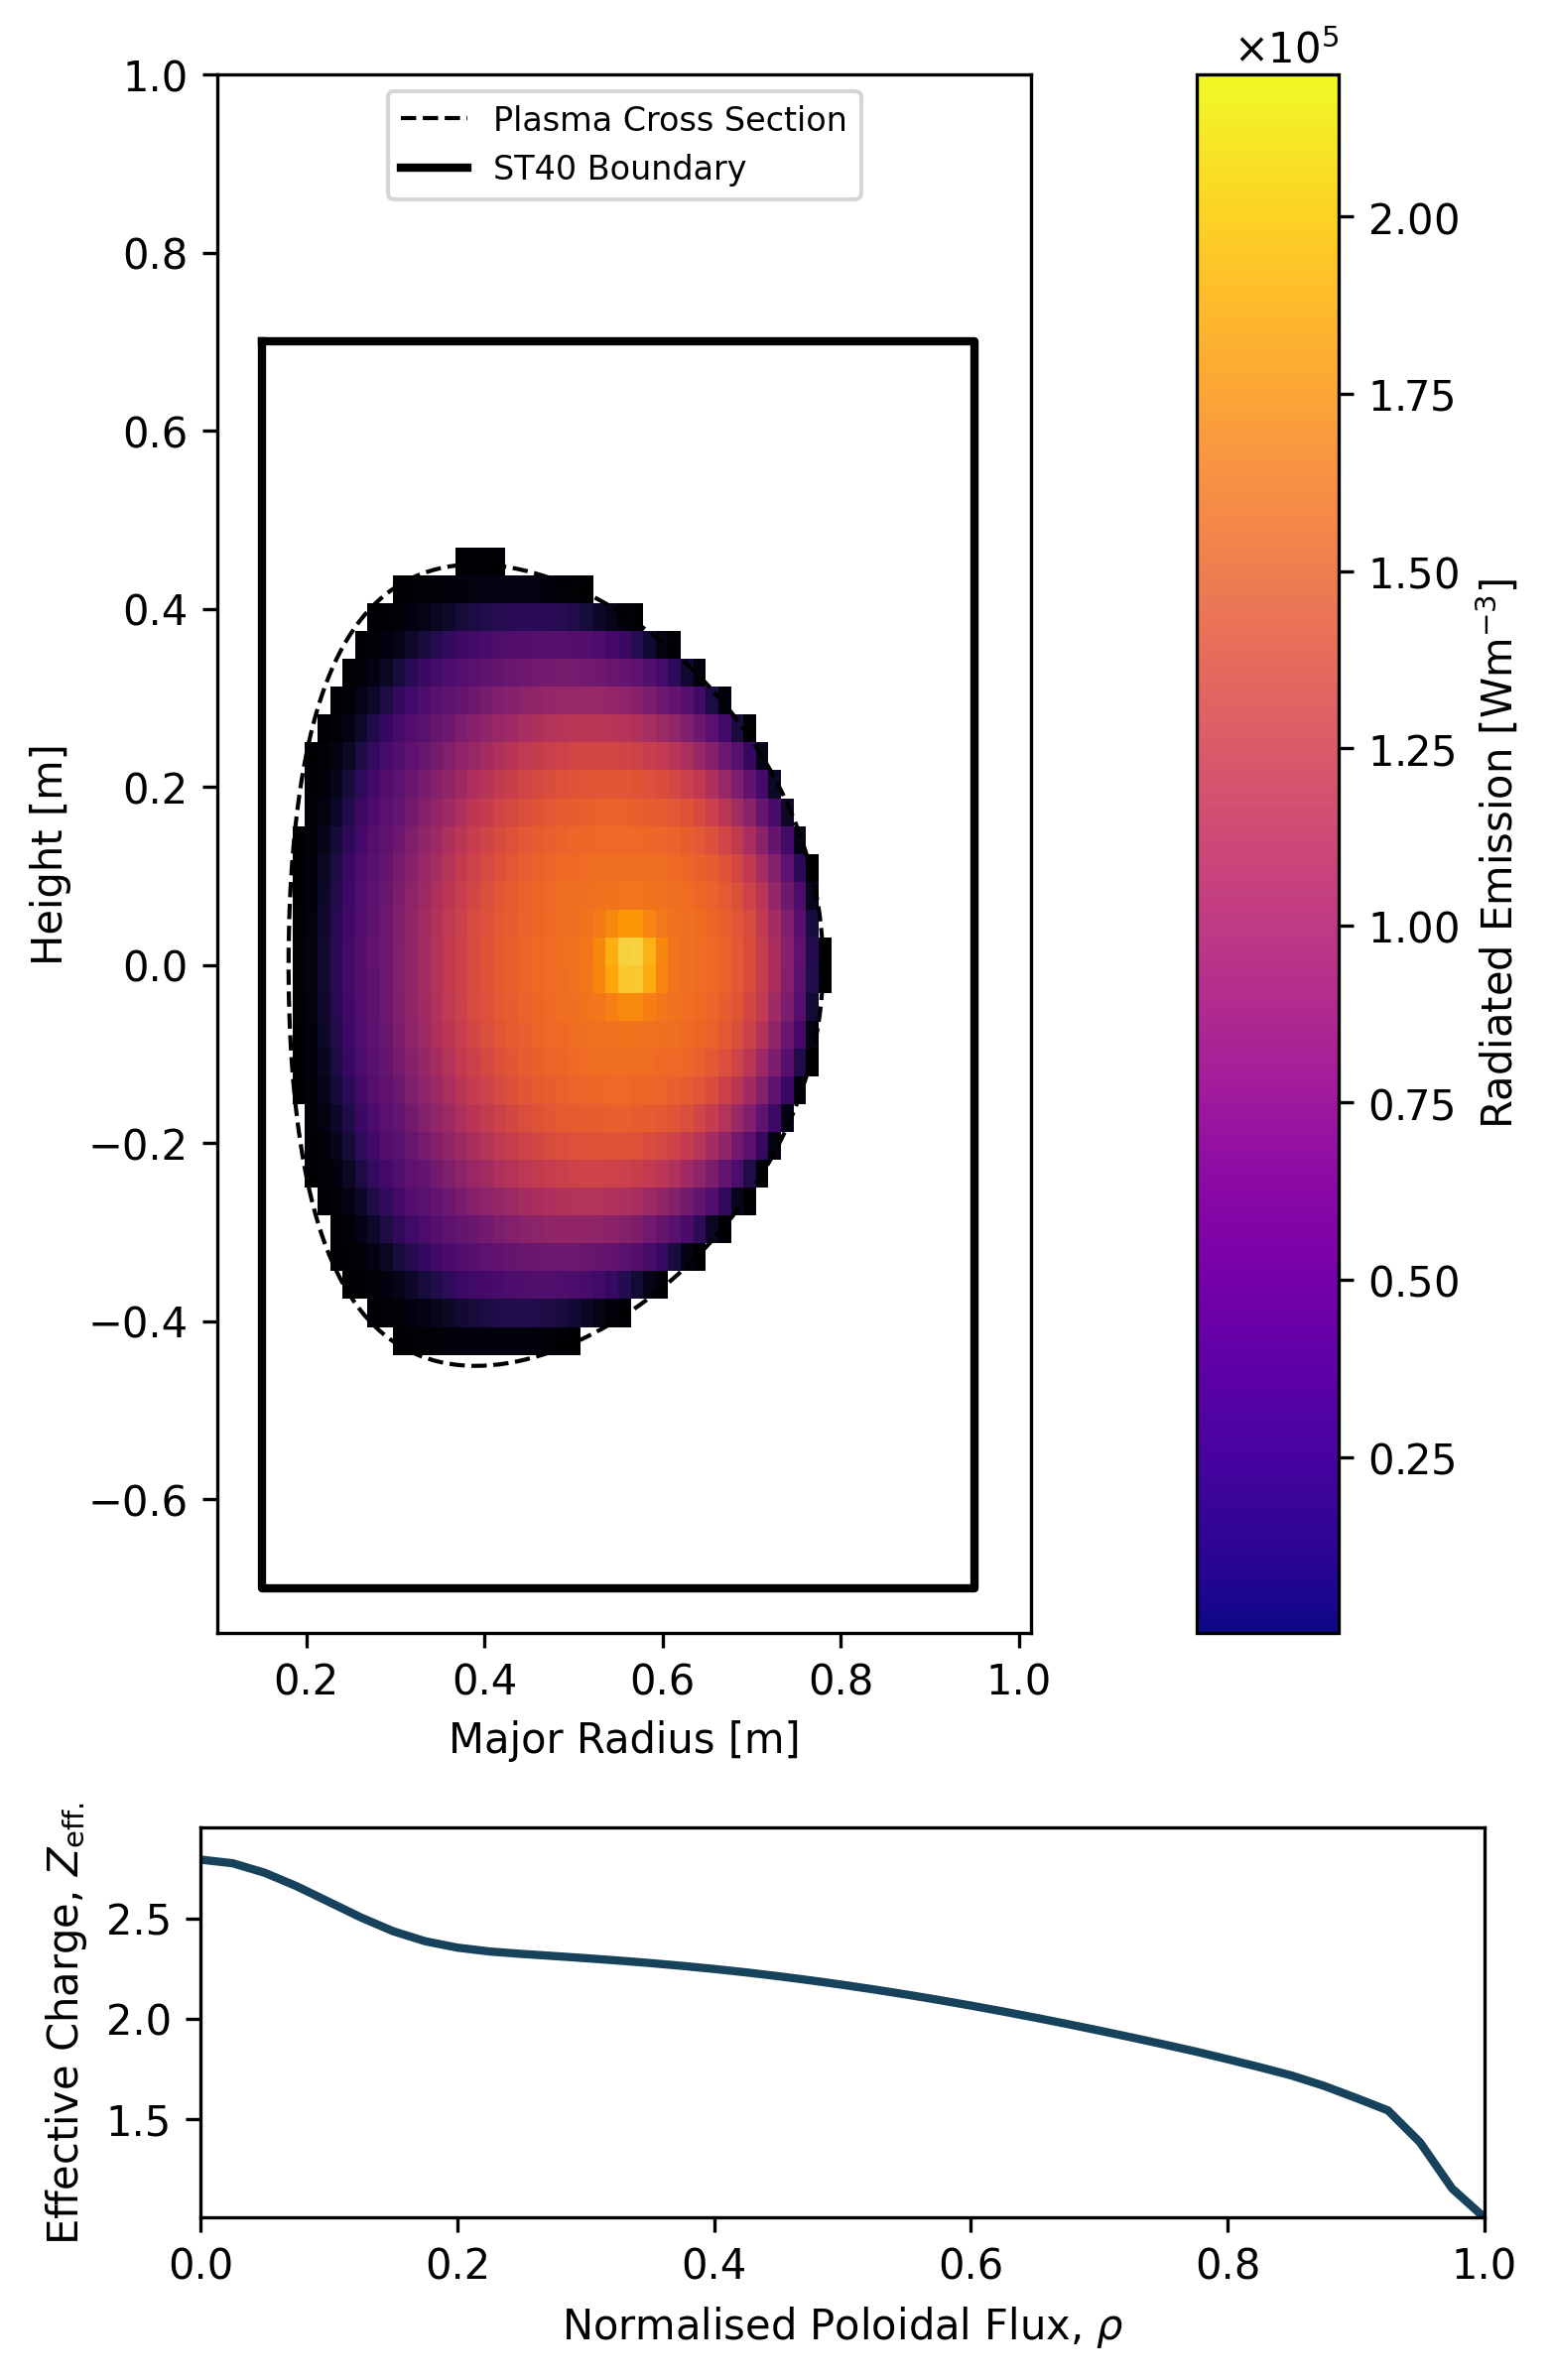

In [161]:
run = 300
plotter.static(is_cbar=True, name=f"states_{run}", run=run)

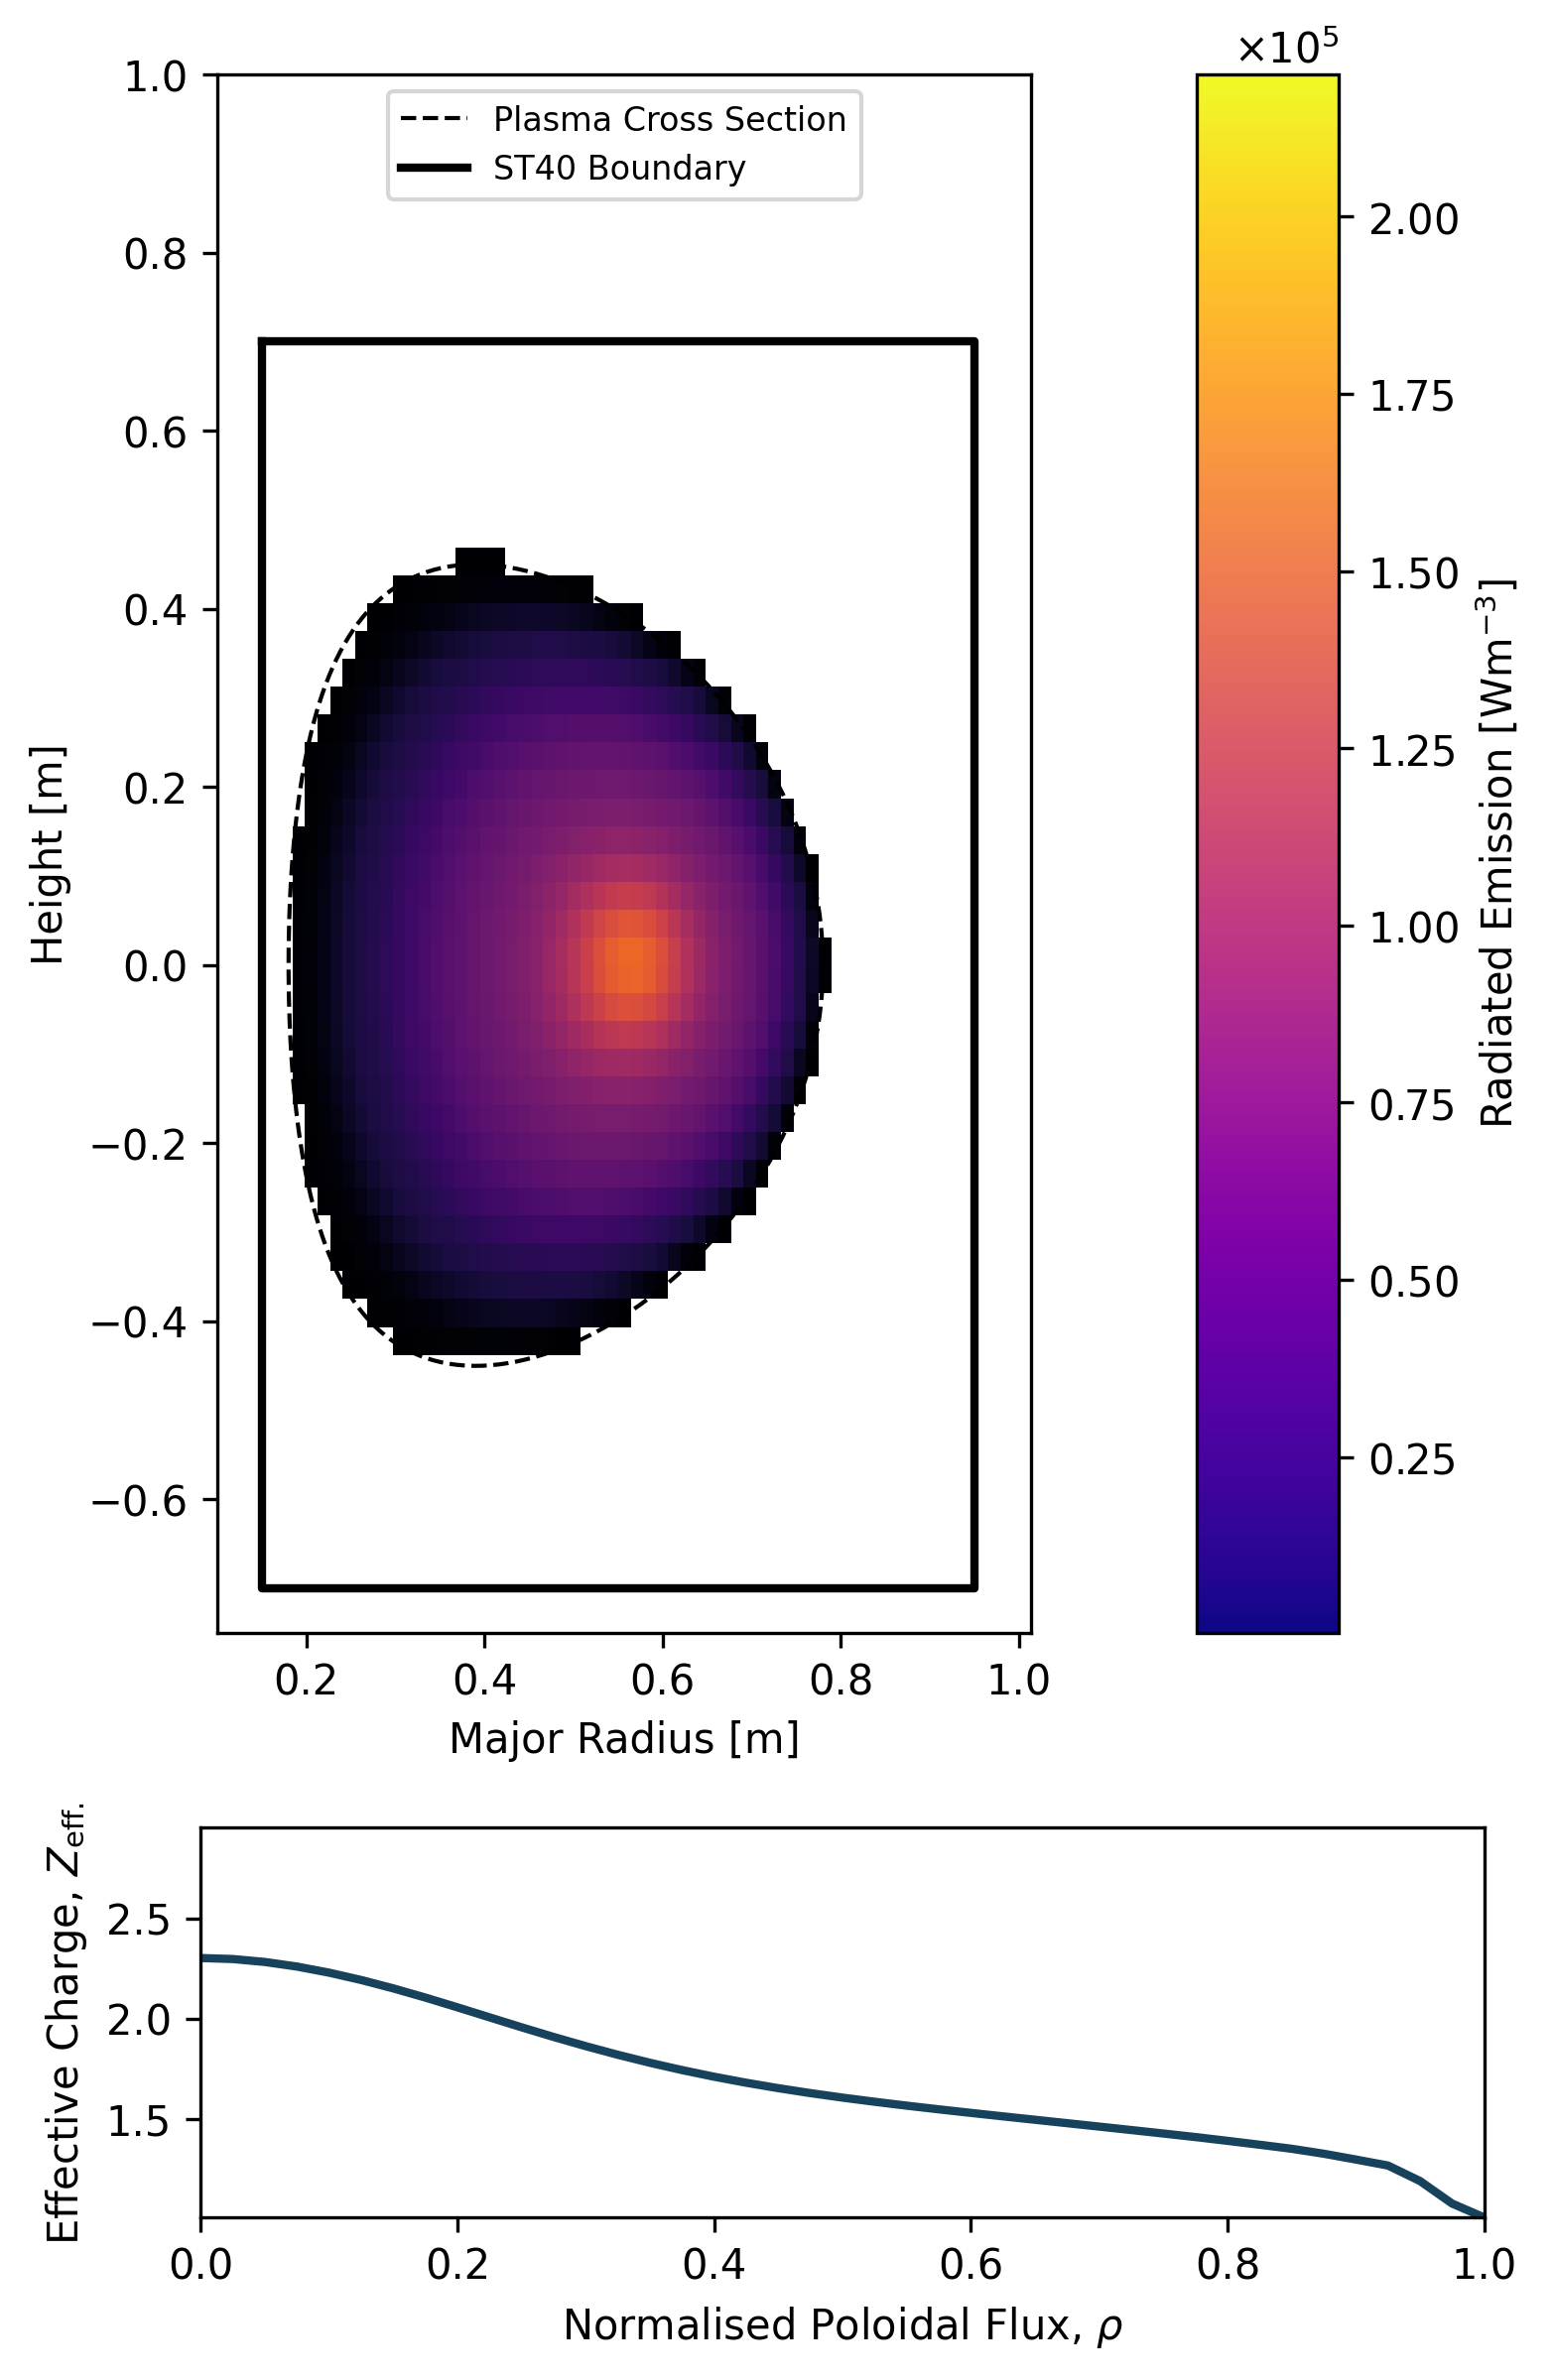

In [156]:
plotter.animate(is_cbar=True, name=f"states", n_frames=100)